In [2]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("archive/fraudTrain.csv")
test_df  = pd.read_csv("archive/fraudTest.csv")


In [3]:
train_df.shape, test_df.shape


((1296675, 23), (555719, 23))

In [4]:
train_df["is_fraud"].value_counts()


is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [5]:
train_df["is_fraud"].value_counts(normalize=True) * 100


is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64

In [6]:
train_df.isnull().sum().sort_values(ascending=False).head(10)


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
dtype: int64

In [7]:
drop_cols = [
    "Unnamed: 0",
    "trans_num",
    "first",
    "last",
    "street",
    "city",
    "state",
    "zip",
    "job",
    "dob"
]

train_df = train_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)


In [8]:
train_df.shape
train_df.columns


Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

# EDA

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt 

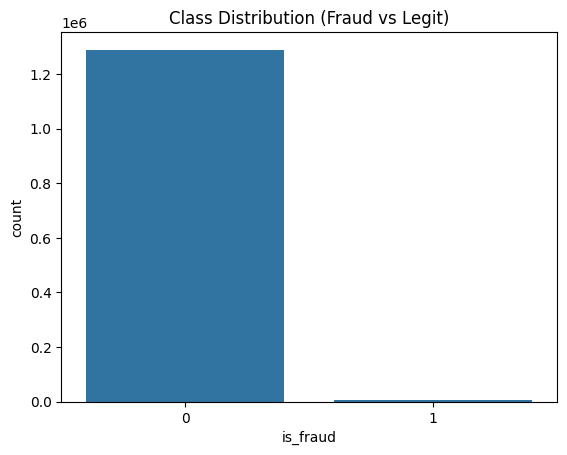

In [10]:
sns.countplot(x="is_fraud", data=train_df)
plt.title("Class Distribution (Fraud vs Legit)")
plt.show()


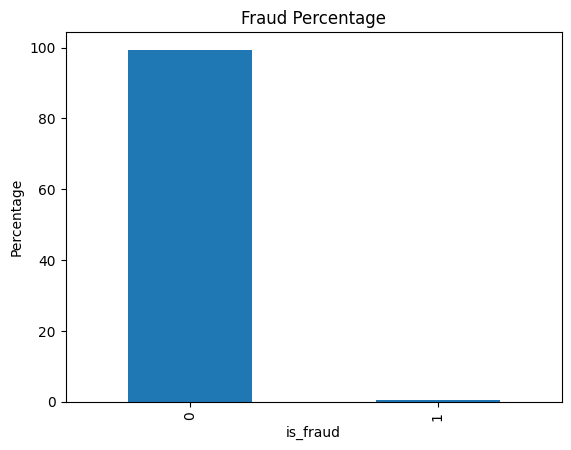

In [11]:
(train_df["is_fraud"]
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind="bar"))
plt.title("Fraud Percentage")
plt.ylabel("Percentage")
plt.show()


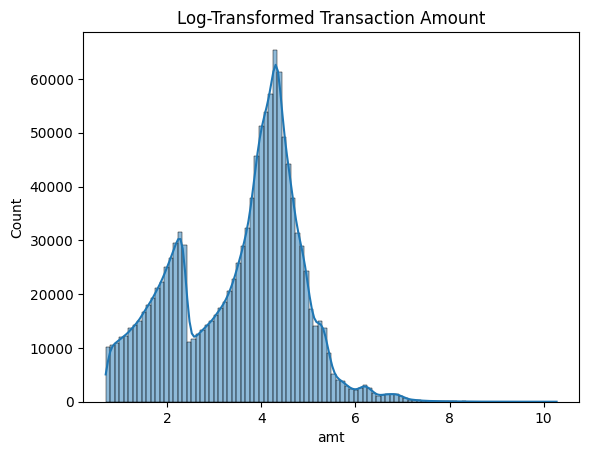

In [12]:
sns.histplot(np.log1p(train_df["amt"]), bins=100, kde=True)
plt.title("Log-Transformed Transaction Amount")
plt.show()


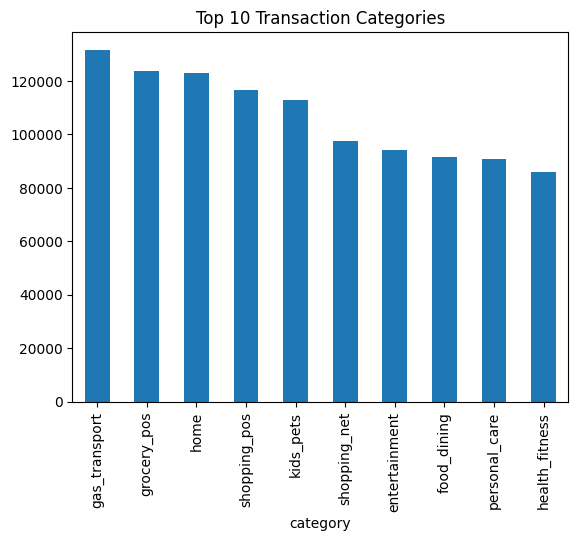

In [13]:
train_df["category"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Transaction Categories")
plt.show()


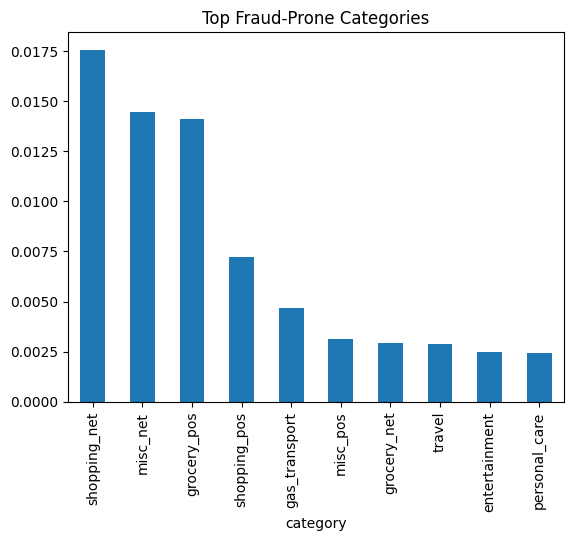

In [14]:
(train_df.groupby("category")["is_fraud"]
 .mean()
 .sort_values(ascending=False)
 .head(10)
 .plot(kind="bar"))
plt.title("Top Fraud-Prone Categories")
plt.show()


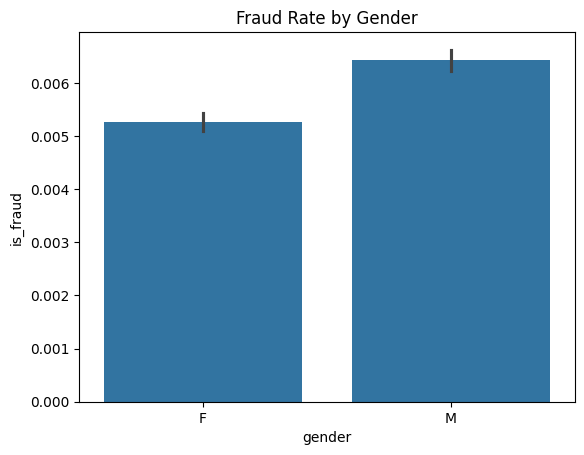

In [16]:
sns.barplot(
    x="gender",
    y="is_fraud",
    data=train_df,
    estimator=np.mean
)
plt.title("Fraud Rate by Gender")
plt.show()



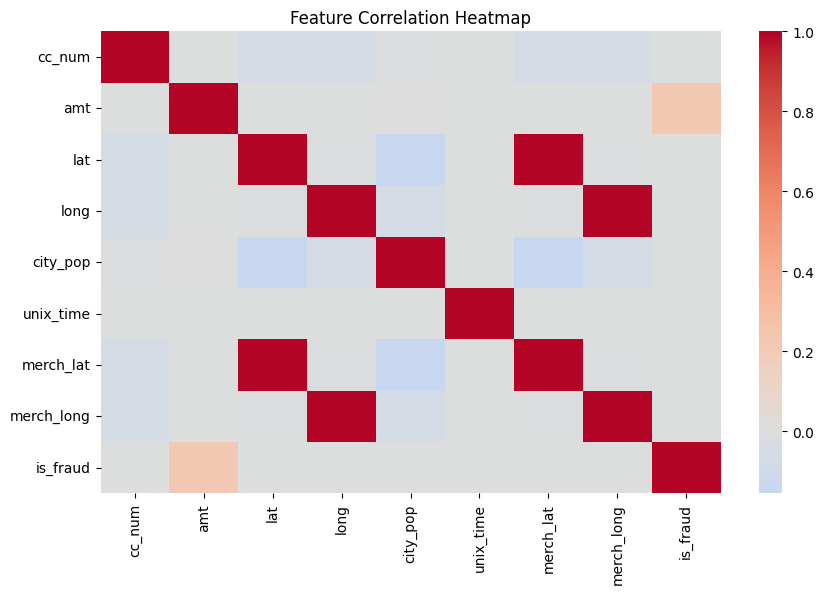

In [17]:
corr = train_df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


# PROPER FEATURE ENGINEERING

In [18]:
import numpy as np

for df in [train_df, test_df]:
    df["amt_log"] = np.log1p(df["amt"])
    df.drop(columns=["amt"], inplace=True)


In [19]:
for df in [train_df, test_df]:
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df["hour"]  = df["trans_date_trans_time"].dt.hour
    df["day"]   = df["trans_date_trans_time"].dt.day
    df["month"] = df["trans_date_trans_time"].dt.month
    df.drop(columns=["trans_date_trans_time"], inplace=True)


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



In [21]:
cat_cols = train_df.select_dtypes(include="object").columns
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=True,
            min_frequency=10
        ), cat_cols)
    ]
)


In [23]:
X_train_p = preprocessor.fit_transform(train_df)
X_test_p  = preprocessor.transform(test_df)

# MODEL TRAINING

In [24]:
from sklearn.ensemble import RandomForestClassifier

# ensure target is defined and fit on preprocessed features
y_train = train_df["is_fraud"]

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_p, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support


In [30]:
thresholds = np.arange(0.65, 1, 0.88)
y_prob = rf.predict_proba(X_test_p)[:, 1]
y_test = test_df["is_fraud"].values
for t in thresholds:
    y_pred = (y_prob >= t).astype(int   
)

# PREDICTION

In [39]:
sample_txn = X_test_p[10]

print("Fraud Probability:", rf.predict_proba(sample_txn)[0][1])
print("Prediction:", int(rf.predict_proba(sample_txn)[0][1] >= 0.25))
print("actual:", test_df["is_fraud"].values[10])


Fraud Probability: 0.15070567278516792
Prediction: 0
actual: 0
